In [15]:
import torch
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
#You can change the download to True if you don't have MNIST in your device
train=datasets.MNIST("",train=True,download=False,transform=transforms.Compose([transforms.ToTensor()]))

In [17]:
test=datasets.MNIST("",train=False,download=False,transform=transforms.Compose([transforms.ToTensor()]))
batch=150

In [18]:
train_set=torch.utils.data.DataLoader(train,batch_size=batch,shuffle=True)
test_set=torch.utils.data.DataLoader(test,batch_size=batch,shuffle=True)

In [19]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1).to(device)

In [20]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.subblock_1=nn.Sequential(
            conv3x3(in_channels, out_channels, stride).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU()
        )
        self.subblock_2=nn.Sequential(
            conv3x3(out_channels, out_channels).to(device),
            nn.BatchNorm2d(out_channels).to(device),
            nn.ReLU(),
        )
        self.downsample = downsample
    def forward(self, x):
        residual = x
        x = self.subblock_1(x).to(device)
        x = self.subblock_2(x).to(device)
        if self.downsample:
            residual = self.downsample(residual)
        x += residual
        x = F.relu(x)        
        return x
block=ResidualBlock

In [23]:
# ResNet
class ResNet(nn.Module):
    def __init__(self,num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels=16
        self.layer=nn.Sequential(
            conv3x3(1, 16).to(device),
            nn.BatchNorm2d(16).to(device),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(block,16,2).to(device)
        self.layer2 = self.make_layer(block, 32,2,2).to(device)
        self.layer3 = self.make_layer(block, 64,2,2).to(device)
        self.max_pool = nn.MaxPool2d(5,2).to(device)
        self.fc = nn.Linear(256,num_classes).to(device)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride).to(device),
                nn.BatchNorm2d(out_channels).to(device)
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x=self.layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
net=ResNet()

In [24]:
import torch.optim as optim
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [25]:
loss_list=[]
correct=0
total=0            
for epoch in range(5):
    for data in train_set:  
        X, Y = data  
        net.zero_grad()
#         print(X.shape)
        output = net(X.to(device)) 
        loss = loss_function(output,Y.to(device)) 
        loss_list.append(loss.item())
        torch.autograd.set_detect_anomaly(True)
        loss.backward()  
        optimizer.step()
        for idx, i in enumerate(output):
            if torch.argmax(i) == Y[idx]:
                correct += 1
            total += 1
    print("For iteration:",epoch+1,"Loss is:",loss.item(),"Accuracy is:",(correct/total)*100)  

For iteration: 1 Loss is: 0.1824140101671219 Accuracy is: 82.42166666666667
For iteration: 2 Loss is: 0.029948212206363678 Accuracy is: 90.35083333333334
For iteration: 3 Loss is: 0.018901024013757706 Accuracy is: 93.10611111111112
For iteration: 4 Loss is: 0.039605118334293365 Accuracy is: 94.565
For iteration: 5 Loss is: 0.025747736915946007 Accuracy is: 95.46833333333333


In [26]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_set:
        X, Y = data
        output = net(X.to(device))
        #print(output)
        for idx, i in enumerate(output):
            if torch.argmax(i) == Y[idx]:
                correct += 1
            total += 1

print("Accuracy: ", (correct/total)*100)

Accuracy:  98.59


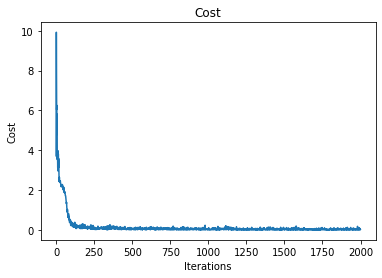

In [27]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost')
plt.show()

In [28]:
#NOW, TESTING THE ABOVE CODE

Given Image is 8


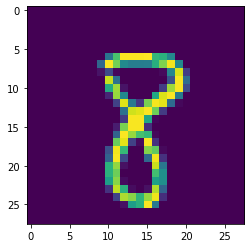

In [29]:
import numpy as np
train_set = datasets.MNIST('./data', train=True, download=False)
test_set = datasets.MNIST('./data', train=False, download=False)
train_img = train_set.data.numpy()
test_img = test_set.data.numpy()
img_tensor=transforms.ToTensor()
req=test_img[4545]
req=img_tensor(req).to(device)
req=req.view(1,1,28,28)
plt.imshow(np.squeeze(test_img[4545]))
output=net(req)
prediction=torch.argmax(output)
print("Given Image is",prediction.item())